Copyright (c) 2021, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

### Colab

Try this notebook on [Colab](http://colab.research.google.com/github/salesforce/ai-economist/blob/master/tutorials/multi_agent_training_with_rllib.ipynb).

### Prerequisites
It is helpful to be familiar with **Foundation**, a multi-agent economic simulator built for the AI Economist ([paper here](https://arxiv.org/abs/2004.13332)). If you haven't worked with Foundation before, we highly recommend taking a look at our other tutorials:

- [Foundation: the Basics](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb)
- [Extending Foundation](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_advanced.ipynb)
- [Optimal Taxation Theory and Simulation](https://github.com/salesforce/ai-economist/blob/master/tutorials/optimal_taxation_theory_and_simulation.ipynb)

## Introduction

Welcome! This tutorial is the first of a series on doing distributed multi-agent reinforcement learning (MARL). Here, we specifically demonstrate how to integrate our multi-agent economic simulation, [Foundation](https://github.com/salesforce/ai-economist/tree/master/ai_economist/foundation), with [RLlib](https://github.com/ray-project/ray/tree/master/rllib), an open-source library for reinforcement learning. We chose to use RLlib, as it provides an easy-to-use and flexible library for MARL. A detailed documentation on RLlib is available [here](https://docs.ray.io/en/master/rllib.html).

We put together these tutorial notebook with the following key goals in mind:
- Provide an exposition to MARL. While there are many libraries and references out there for single-agent RL training, MARL training is not discussed as much, and there aren't many multi-agent rl libraries.
- Provide reference starting code to perform MARL training so the AI Economist community can focus more on building meaningful extensions to Foundation and better-performant algorithms.

We will cover the following concepts in this tutorial:
1. Adding an *environment wrapper* to make the economic simulation compatible with RLlib.
2. Creating a *trainer* object that holds the (multi-agent) policies for environment interaction.
3. Training all the agents in the economic simulation.
4. Generate a rollout using the trainer object and visualize it.

### Dependencies:
You can install the ai-economist package using 
- the pip package manager OR
- by cloning the ai-economist package and installing the requirements (we shall use this when running on Colab):

In [ ]:
import os, signal, sys, time
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone https://github.com/salesforce/ai-economist.git

    %cd ai-economist
    !pip install -e .
    
    # Restart the Python runtime to automatically use the installed packages
    print("\n\nRestarting the Python runtime! Please (re-)run the cells below.")
    time.sleep(1)
    os.kill(os.getpid(), signal.SIGKILL)
else:
    ! pip install ai-economist

Install OpenAI Gym to help define the environment's observation and action spaces for use with RLlib.

In [7]:
!pip install gym==0.21

Install the `RLlib` reinforcement learning library:
- First, install TensorFlow
- Then, install ray[rllib]

Note: RLlib natively supports TensorFlow (including TensorFlow Eager) as well as PyTorch, but most of its internals are framework agnostic. Here's a relevant [blogpost](https://medium.com/distributed-computing-with-ray/lessons-from-implementing-12-deep-rl-algorithms-in-tf-and-pytorch-1b412009297d) that compares running RLlib algorithms with TF and PyTorch. Overall, TF seems to run a bit faster than PyTorch, in our experience, and we will use that in this notebook.

In [8]:
# We install these specific versions of tensorflow and rllib, that we used in our work.
!pip install tensorflow==1.14
!pip install "ray[rllib]==0.8.4"

In [ ]:
# Change directory to the tutorials folder
import os, sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    os.chdir("/content/ai-economist/tutorials")
else:
    os.chdir(os.path.dirname(os.path.abspath("__file__"))
)

## 1. Adding an Environment Wrapper 

We first define a configuration (introduced in [the basics tutorial](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basics.ipynb)) for the "gather-trade-build" environment with multiple mobile agents (that move, gather resources, build or trade) and a social planner that sets taxes according to (a scaled variant of) the 2018 US tax schedule.

In [1]:
# Define a configuration (dictionary) for the "gather-trade-build" environment.

env_config_dict = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'layout_from_file/simple_wood_and_stone',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (1) Building houses
        ('Build', {
            'skill_dist':                   'pareto', 
            'payment_max_skill_multiplier': 3,
            'build_labor':                  10,
            'payment':                      10
        }),
        # (2) Trading collectible resources
        ('ContinuousDoubleAuction', {
            'max_bid_ask':    10,
            'order_labor':    0.25,
            'max_num_orders': 5,
            'order_duration': 50
        }),
        # (3) Movement and resource collection
        ('Gather', {
            'move_labor':    1,
            'collect_labor': 1,
            'skill_dist':    'pareto'
        }),
        # (4) Planner
        ('PeriodicBracketTax', {
            'period':          100,
            'bracket_spacing': 'us-federal',
            'usd_scaling':     1000,
            'disable_taxes':   False
        })
    ],
    
    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'env_layout_file': 'quadrant_25x25_20each_30clump.txt',
    'starting_agent_coin': 10,
    'fixed_four_skill_and_loc': True,
    
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 4,          # Number of non-planner agents (must be > 1)
    'world_size': [25, 25], # [Height, Width] of the env world
    'episode_length': 1000, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': True,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
    
    # How often to save the dense logs
    'dense_log_frequency': 1
}

Like we have seen in earlier [tutorials](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb), using `env = foundation.make_env_instance(**env_config)` creates an environment instance `env` with the specified configuration.

In order to use this environment with RLlib, we will also need to add the environment's `observation_space` and `action_space` attributes. Additionally, the environment itself must subclass the [`MultiAgentEnv`](https://github.com/ray-project/ray/blob/master/rllib/env/multi_agent_env.py) interface, which can return observations and rewards from multiple ready agents per step. To this end, we use an environment [wrapper](https://github.com/salesforce/ai-economist/blob/master/tutorials/rllib/env_wrapper.py).

In [2]:
from rllib.env_wrapper import RLlibEnvWrapper
env_obj = RLlibEnvWrapper({"env_config_dict": env_config_dict}, verbose=True)

Inside covid19_components.py: 1 GPUs are available.
Inside covid19_env.py: 1 GPUs are available.


/home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akash/miniconda3/envs/

[EnvWrapper] Spaces
[EnvWrapper] Obs (a)   
action_mask    : (50,)
flat           : (136,)
time           : (1,)
world-idx_map  : (2, 11, 11)
world-map      : (7, 11, 11)


[EnvWrapper] Obs (p)   
action_mask    : (154,)
flat           : (86,)
p0             : (8,)
p1             : (8,)
p2             : (8,)
p3             : (8,)
time           : (1,)
world-idx_map  : (2, 25, 25)
world-map      : (6, 25, 25)


[EnvWrapper] Action (a) Discrete(50)
[EnvWrapper] Action (p) MultiDiscrete([22 22 22 22 22 22 22])


Upon applying the wrapper to our environment, we have now defined observation and action spaces for the agents and the planner, indicated with `(a)` and `(p)` respectively. Also, (a useful tip) you can still access the environment instance and its attributes simply by using `env_obj.env`

In summary, the observation spaces are represented as `Box` objects and the action spaces as `Discrete` objects (for more details on these types, see the OpenAI documentation [page](https://gym.openai.com/docs/#spaces)).

Briefly looking at the shapes of the observation features (the numbers in parentheses), you will see that we have some one-dimensional features (e.g. `action-mask`, `flat`, `time`) as well as spatial features (e.g., `world-idx-map`, `world-map`)

A couple of quick notes:
- An `action_mask` is used to mask out the actions that are not allowed by the environment. For instance, a mobile agent cannot move beyond the boundary of the world. Hence, in position (0, 0), a mobile cannot move "Left" or "Down", and the corresponding actions in the mask would be nulled out. Now, the RL agent can still recommend to move "Left" or "Down", but the action isn't really taken.
- The key `flat` arises since we set `flatten_observations': True`. Accordingly, the scalar and vector raw observations are all concatenated into this single key. If you're curious to see the entire set of raw observations, do set `flatten_observations': False` in the env_config, and re-run the above cell.

Looking at the action spaces, the mobile agents can take 50 possible actions (including 1 NO-OP action or do nothing (always indexed 0), 44 trading-related actions, 4 move actions along the four directions and 1 build action)

The planner sets the tax rates for 7 brackets, each from 0-100% in steps of 5%, so that's 21 values. Adding the NO-OP action brings the planner action space to `MultiDiscrete([22 22 22 22 22 22 22])`.

## 2. Creating a *Trainer* Object

In order to train our economic simulation environment with RLlib, you will need familiarity with one of the key classes: the [`Trainer`](https://docs.ray.io/en/master/rllib-training.html). The trainer object maintains the relationships that connect each agent in the environment to its corresponding trainable policy, and essentially helps in training, checkpointing policies and inferring actions. It helps to co-ordinate the workflow of collecting rollouts and optimizing the various policies via a reinforcement learning algorithm. Inherently, RLlib maintains a wide suite of [algorithms](https://docs.ray.io/en/master/rllib-algorithms.html) for multi-agent learning (which was another strong reason for us to consider using RLlib) - available options include SAC, PPO, PG, A2C, A3C, IMPALA, ES, DDPG, DQN, MARWIL, APEX, and APEX_DDPG. For the remainder of this tutorial, we will stick to using [Proximal Policy Optimization](https://openai.com/blog/openai-baselines-ppo/) (PPO), an algorithm known to perform well generally.

Every algorithm has a corresponding trainer object; in the context of PPO, we invoke the `PPOTrainer` object.

In [3]:
import ray
from ray.rllib.agents.ppo import PPOTrainer

PPOTrainer can be instantiated with 
- `env`: an environment creator (i.e, RLlibEnvWrapper() in our case)
- `config`: algorithm-specific configuration data for setting the various components of the RL training loop including the environment, rollout worker processes, training resources, degree of parallelism, framework used, and the policy exploration strategies.

Note: There are several configuration settings related to policy architectures, rollout collection, minibatching, and other important hyperparameters, that need to be set carefully in order to train effectively. For the sake of the high-level exposition, we allow RLlib to use most of the the default settings. Check out the list of default [common configuration parameters](https://docs.ray.io/en/releases-0.8.4/rllib-training.html#common-parameters) and default [PPO-specific configuration parameters](https://docs.ray.io/en/releases-0.8.4/rllib-algorithms.html?highlight=PPO#proximal-policy-optimization-ppo). Custom environment configurations may be passed to environment creator via `config["env_config"]`.

RLlib also chooses default built-in [models](https://docs.ray.io/en/releases-0.8.4/rllib-models.html#built-in-models-and-preprocessors) for processing the observations. The models are picked based on a simple heuristic: a [vision](https://github.com/ray-project/ray/blob/master/rllib/models/tf/visionnet.py) network for observations that have shape of length larger than 2 (for example, (84 x 84 x 3)), and a [fully connected](https://github.com/ray-project/ray/blob/master/rllib/models/tf/fcnet.py) network for everything else. Custom models can be configured via the `config["policy"]["model"]` key.

In the context of multi-agent training, we will also need to set the multi-agent configuration:
```python
"multiagent": {
        # Map of type MultiAgentPolicyConfigDict from policy ids to tuples
        # of (policy_cls, obs_space, act_space, config). This defines the
        # observation and action spaces of the policies and any extra config.
        "policies": {},
        # Function mapping agent ids to policy ids.
        "policy_mapping_fn": None,
        # Optional list of policies to train, or None for all policies.
        "policies_to_train": None,
    },
```

To this end, let's notate the agent policy id by `"a"` and the planner policy id by `"p"`. We can set `policies`, `policy_mapping_fun` and `policies_to_train` as follows.

In [4]:
policies = {
    "a": (
        None,  # uses default policy
        env_obj.observation_space,
        env_obj.action_space,
        {}  # define a custom agent policy configuration.
    ),
    "p": (
        None,  # uses default policy
        env_obj.observation_space_pl,
        env_obj.action_space_pl,
        {}  # define a custom planner policy configuration.
    )
}

# In foundation, all the agents have integer ids and the social planner has an id of "p"
policy_mapping_fun = lambda i: "a" if str(i).isdigit() else "p"

policies_to_train = ["a", "p"]

Create a multiagent trainer config holding the trainable policies and their mappings.

In [5]:
trainer_config = {
    "multiagent": {
        "policies": policies,
        "policies_to_train": policies_to_train,
        "policy_mapping_fn": policy_mapping_fun,
    }
}

With distributed RL, architectures typically comprise several **roll-out** and **trainer** workers operating in tandem
![](assets/distributed_rl_architecture.png)

The roll-out workers repeatedly step through the environment to generate and collect roll-outs in parallel, using the actions sampled from the policy models on the roll-out workers or provided by the trainer worker.
Roll-out workers typically use CPU machines, and sometimes, GPU machines for richer environments.
Trainer workers gather the roll-out data (asynchronously) from the roll-out workers and optimize policies on CPU or GPU machines.

In this context, we can also add a `num_workers` configuration parameter to specify the number of rollout workers, i.e, those responsible for gathering rollouts. Note: setting `num_workers=0` will mean the rollouts will be collected by the trainer worker itself. Also, each worker can collect rollouts from multiple environments in parallel, which is specified in `num_envs_per_worker`; there will be a total of `num_workers` $\times$ `num_envs_per_worker` environment replicas used to gather rollouts.
Note: below, we also update some of the default trainer settings to keep the iteration time small.

In [6]:
trainer_config.update(
    {
        "num_workers": 2,
        "num_envs_per_worker": 2,
        # Other training parameters
        "train_batch_size":  4000,
        "sgd_minibatch_size": 4000,
        "num_sgd_iter": 1
    }
)

Finally, we need to add the environment configuration to the trainer configuration.

In [7]:
# We also add the "num_envs_per_worker" parameter for the env. wrapper to index the environments.
env_config = {
    "env_config_dict": env_config_dict,
    "num_envs_per_worker": trainer_config.get('num_envs_per_worker'),   
}

trainer_config.update(
    {
        "env_config": env_config        
    }
)

One the training configuration is set, we will need to initialize ray and create the PPOTrainer object.

In [8]:
# Initialize Ray
ray.init(webui_host="127.0.0.1")

2023-05-20 22:02:06,338	INFO resource_spec.py:212 -- Starting Ray with 2.49 GiB memory available for workers and up to 1.26 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2023-05-20 22:02:06,676	INFO services.py:1148 -- View the Ray dashboard at 127.0.0.1:8266


{'node_ip_address': '172.16.11.214',
 'redis_address': '172.16.11.214:28359',
 'object_store_address': '/tmp/ray/session_2023-05-20_22-02-06_286965_5494/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2023-05-20_22-02-06_286965_5494/sockets/raylet',
 'webui_url': '127.0.0.1:8266',
 'session_dir': '/tmp/ray/session_2023-05-20_22-02-06_286965_5494'}

In [37]:
trainer_config.keys()

dict_keys(['multiagent', 'num_workers', 'num_envs_per_worker', 'train_batch_size', 'sgd_minibatch_size', 'num_sgd_iter', 'env_config'])

In [9]:
# Create the PPO trainer.
trainer = PPOTrainer(
    env=RLlibEnvWrapper,
    config=trainer_config,
    )

2023-05-20 22:02:07,948	INFO trainer.py:428 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2023-05-20 22:02:07,970	ERROR syncer.py:39 -- Log sync requires rsync to be installed.
2023-05-20 22:02:07,972	INFO trainer.py:585 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


(pid=5598) /home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=5598)   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
(pid=5598) /home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=5598)   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
(pid=5598) /home/akash/miniconda3/envs/ai_economist/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
(pid=5598)   _np_qint16 

(pid=5598) Inside covid19_components.py: 1 GPUs are available.
(pid=5600) Inside covid19_components.py: 1 GPUs are available.
(pid=5598) Inside covid19_env.py: 1 GPUs are available.
(pid=5600) Inside covid19_env.py: 1 GPUs are available.


2023-05-20 22:02:44,939	INFO trainable.py:180 -- _setup took 36.968 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2023-05-20 22:02:44,940	INFO trainable.py:217 -- Getting current IP.


## 3. Perform Training

And that's it! We are now ready to perform training by invoking `trainer.train()`; we call it for just a few number of iterations.

In [15]:
NUM_ITERS = 5
for iteration in range(NUM_ITERS):
    print(f'********** Iter : {iteration} **********')
    result = trainer.train()
    print(f'''episode_reward_mean: {result.get('episode_reward_mean')}''')

********** Iter : 0 **********
episode_reward_mean: -81.82828508800041
********** Iter : 1 **********
episode_reward_mean: -74.1345233190103
********** Iter : 2 **********
episode_reward_mean: -66.71534027673356
********** Iter : 3 **********
episode_reward_mean: -65.90353937894339
********** Iter : 4 **********
episode_reward_mean: -63.071809104163904


By default, the results will be logged to a subdirectory of `~/ray_results`. This subdirectory will contain a file `params.json` which contains the hyperparameters, a file `result.json` which contains a training summary for each episode and a TensorBoard file that can be used to visualize training process with TensorBoard by running|
```shell
tensorboard --logdir ~/ray_results
```

## 4. Generate and Visualize the Environment's Dense Logs

At any point during training, we would also want to inspect the environment's dense logs in order to deep-dive into the training results. Introduced in our [basic tutorial](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb#Visualize-using-dense-logging), dense logs are basically logs of each agent's states, actions and rewards at every point in time, along with a snapshot of the world state.

There are two equivalent ways to fetch the environment's dense logs using the trainer object.

a. Simply retrieve the dense log from the workers' environment objects

b. Generate dense log(s) from the most recent trainer policy model weights

### 4a. Simply retrieve the dense log from the workers' environment objects

From each rollout worker, it's straightforward to retrieve the dense logs using some of the function attributes.

In [10]:
# Below, we fetch the dense logs for each rollout worker and environment within

dense_logs = {}
# Note: worker 0 is reserved for the trainer actor
for worker in range((trainer_config["num_workers"] > 0), trainer_config["num_workers"] + 1):
    for env_id in range(trainer_config["num_envs_per_worker"]):
        dense_logs["worker={};env_id={}".format(worker, env_id)] = \
        trainer.workers.foreach_worker(lambda w: w.async_env)[worker].envs[env_id].env.previous_episode_dense_log

In [11]:
# We should have num_workers x num_envs_per_worker number of dense logs
print(dense_logs.keys())

dict_keys(['worker=1;env_id=0', 'worker=1;env_id=1', 'worker=2;env_id=0', 'worker=2;env_id=1'])


### 4b. Generate a dense log from the most recent trainer policy model weights

We may also use the trainer object directly to play out an episode. The advantage of this approach is that we can re-sample the policy model any number of times and generate several rollouts.

In [23]:
env_obj == trainer.workers.local_worker().env

False

In [24]:
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()   

In [34]:
obs = trainer.workers.local_worker().env.env.reset()

In [35]:
 trainer.compute_action(
                    obs[str(0)], 
                    agent_states[str(0)], 
                    policy_id="a",
                    full_fetch=False
                )

29

In [17]:
def generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=1
):
    global x
    dense_logs = {}
    for idx in range(num_dense_logs):
        # Set initial states
        agent_states = {}
        for agent_idx in range(env_obj.env.n_agents):
            agent_states[str(agent_idx)] = trainer.get_policy("a").get_initial_state()
        planner_states = trainer.get_policy("p").get_initial_state()   

        # Play out the episode
        obs = env_obj.reset(force_dense_logging=True)
        for t in range(env_obj.env.episode_length):
            actions = {}
            for agent_idx in range(env_obj.env.n_agents):
                # Use the trainer object directly to sample actions for each agent
                actions[str(agent_idx)] = trainer.compute_action(
                    obs[str(agent_idx)], 
                    agent_states[str(agent_idx)], 
                    policy_id="a",
                    full_fetch=False
                )

            # Action sampling for the planner
            actions["p"] = trainer.compute_action(
                obs['p'], 
                planner_states, 
                policy_id='p',
                full_fetch=False
            )
            
            x = actions
            print(x)
            break
            obs, rew, done, info = env_obj.step(actions)        
            if done['__all__']:
                break
        dense_logs[idx] = env_obj.env.dense_log
    return dense_logs

In [18]:
dense_logs = generate_rollout_from_current_trainer_policy(
    trainer, 
    env_obj,
    num_dense_logs=2
)

{'0': 1, '1': 44, '2': 25, '3': 14, 'p': array([ 4,  4, 12,  5, 10, 11,  8])}
{'0': 36, '1': 15, '2': 45, '3': 24, 'p': array([ 4,  9,  5, 12, 18, 10,  8])}


In [20]:
x

{'0': 36, '1': 15, '2': 45, '3': 24, 'p': array([ 4,  9,  5, 12, 18, 10,  8])}

### Visualizing the episode dense logs

Once we obtain the dense logs, we can use the plotting utilities we have created to examine the episode dense logs and visualize the the world state, agent-wise quantities, movement, and trading events.

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   4.47 (n= 43) |   4.46 (n= 54) |   4.71 (n= 59) |   4.12 (n= 60)
Cost (Stone)   :   6.50 (n= 22) |   6.43 (n= 37) |   6.46 (n= 50) |   5.60 (n= 45)

Income (Wood)  :   4.28 (n= 39) |   4.47 (n= 49) |   4.15 (n= 72) |   4.88 (n= 56)
Income (Stone) :   6.86 (n= 21) |   6.02 (n= 41) |   5.96 (n= 54) |   6.39 (n= 38)
Income (Build) :  22.25 (n=  1) |  13.27 (n=  3) |  16.47 (n=  7) |  11.33 (n=  7)


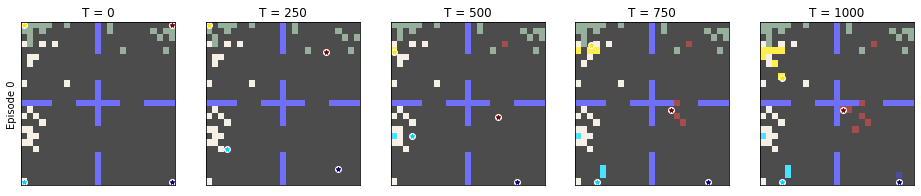

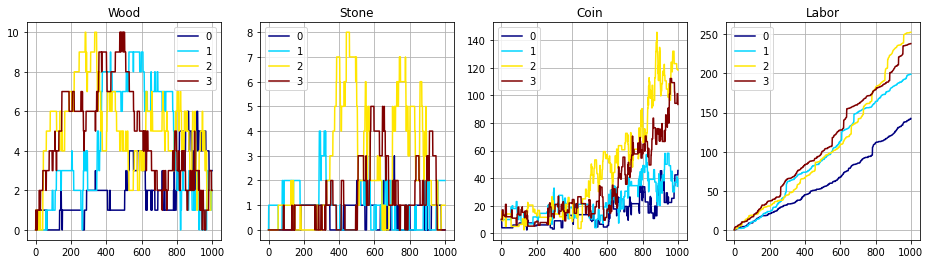

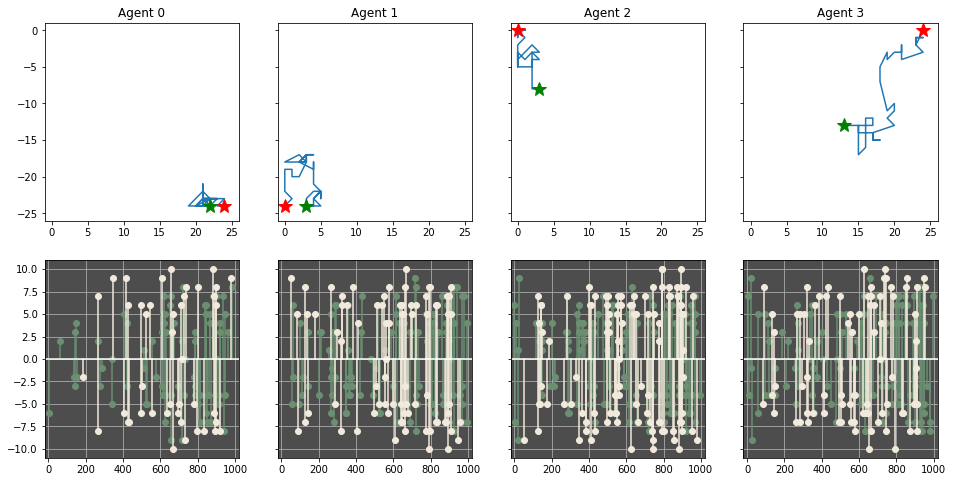

In [20]:
from utils import plotting  # plotting utilities for visualizing env. state

dense_log_idx = 0
plotting.breakdown(dense_logs[dense_log_idx]);

In [21]:
# Shutdown Ray after use
ray.shutdown()

And that's it for now. See you in the [next](https://github.com/salesforce/ai-economist/blob/master/tutorials/two_level_curriculum_learning_with_rllib.md) tutorial :)